In [1]:
import pyspark

In [2]:
from pyspark import SparkContext, SparkConf

In [3]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, StringType, DateType, FloatType
from pyspark.sql.functions import lit, array, explode, min as spark_min, max as spark_max, col

In [4]:
schema=StructType([    
    StructField('dateTime', DateType(), True),
    StructField('open', FloatType(), True),
    StructField('high', FloatType(), True),
    StructField('low', FloatType(), True),
    StructField('close', FloatType(), True),
    StructField('volume', FloatType(), True),
])

In [5]:
df = spark.read.csv("/user/root/input/output_BTCUSDT.csv", sep=',',header=True,schema=schema,inferSchema=True)

In [6]:
df.show()

+----------+-------+-------+-------+-------+----------+
|  dateTime|   open|   high|    low|  close|    volume|
+----------+-------+-------+-------+-------+----------+
|2017-08-17|4261.48|4485.39|4200.74|4285.08|  795.1504|
|2017-08-18|4285.08|4371.52|3938.77|4108.37| 1199.8883|
|2017-08-19|4108.37|4184.69| 3850.0|4139.98| 381.30975|
|2017-08-20|4120.98|4211.08|4032.62|4086.29|   467.083|
|2017-08-21|4069.13|4119.62|3911.79| 4016.0| 691.74304|
|2017-08-22| 4016.0|4104.82| 3400.0| 4040.0|  966.6849|
|2017-08-23| 4040.0| 4265.8|4013.89|4114.01|1001.13654|
|2017-08-24| 4147.0|4371.68|4085.01|4316.01| 787.41876|
|2017-08-25|4316.01|4453.91|4247.48|4280.68| 573.61273|
|2017-08-26|4280.71| 4367.0|4212.41|4337.44| 228.10806|
|2017-08-27|4332.51| 4400.0|4285.54|4310.01|  350.6926|
|2017-08-28|4310.01|4399.82|4124.54|4386.69|  603.8416|
|2017-08-29|4353.65|4625.85|4313.55|4587.48| 603.54504|
|2017-08-30|4564.52|4647.51|4416.01|4555.14| 808.46875|
|2017-08-31|4555.14|4745.42|4555.14|4724.89|  55

In [7]:
#  check null & NaN
from pyspark.sql import functions as F
df.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df.columns
]).show()

+--------+----+----+---+-----+------+
|dateTime|open|high|low|close|volume|
+--------+----+----+---+-----+------+
|       0|   0|   0|  0|    0|     0|
+--------+----+----+---+-----+------+



In [8]:
def length(data):
    count = 0
    for n in data:
        count+=1
    return count
def sum(data):
    sum = 0
    for value in data:
        sum+=value
    return sum
def min(data):
    min = data[0]
    for i in range(1, length(data)):
        if min > data[i]:
            min = data[i]

    return min

def max(data):
    max = data[0]
    for i in range(1, length(data)):
        if max < data[i]:
            max = data[i]

    return max

def qsort(data):
    if len(data) <= 1:
        return data
    
    pivot = data[0]
    
    left = [i for i in data[1:] if i <= pivot]
    right = [i for i in data[1:] if i > pivot]
    
    return qsort(left) + [pivot] + qsort(right)

In [9]:
def describe(data):
    description = {}
    col_values = []
    dem = 0
    for col in data.columns:
        if dem == 0:
            dem += 1
            continue 
            
        col_values = [element[col] for element in data.select(col).collect()]
        count = length(col_values)
        mean = sum(col_values) / count
        std = (sum((x - mean) ** 2 for x in col_values) / (count - 1)) ** 0.5
        min_val = min(col_values)
        max_val = max(col_values)
        sorted_values = qsort(col_values)
        q25 = sorted_values[int(0.25 * (count - 1))]
        median = sorted_values[int(0.5 * (count - 1))]
        q75 = sorted_values[int(0.75 * (count - 1))]
    
        description[col] = {
            'count': count,
            'mean': mean,
            'std': std,
            'min': min_val,
            '25%': q25,
            '50%': median,
            '75%': q75,
            'max': max_val,
        }


    return description

In [10]:
des_data = describe(df)

In [11]:
from tabulate import tabulate
def show(data):
    headers = ["Metric"] + list(data.keys())
    rows = []
    
    metrics = list(data['open'].keys())
    for metric in metrics:
        row = [metric]
        for key in data.keys():
            row.append(data[key][metric])
        rows.append(row)
    
    print(tabulate(rows, headers=headers, tablefmt="grid"))

show(des_data)

+----------+----------+---------+----------+----------+------------+
| Metric   |     open |    high |      low |    close |     volume |
+==========+==========+=========+==========+==========+============+
| count    |  2481    |  2481   |  2481    |  2481    |   2481     |
+----------+----------+---------+----------+----------+------------+
| mean     | 23195.2  | 23783.6 | 22552.1  | 23220.8  |  71347.8   |
+----------+----------+---------+----------+----------+------------+
| std      | 18040.1  | 18485   | 17549.1  | 18058.3  |  82509     |
+----------+----------+---------+----------+----------+------------+
| min      |  3188.01 |  3276.5 |  2817    |  3189.02 |    228.108 |
+----------+----------+---------+----------+----------+------------+
| 25%      |  8170.79 |  8325   |  7900.28 |  8170    |  29544.9   |
+----------+----------+---------+----------+----------+------------+
| 50%      | 17165.5  | 17695   | 16878.2  | 17178.3  |  45693     |
+----------+----------+---------+-

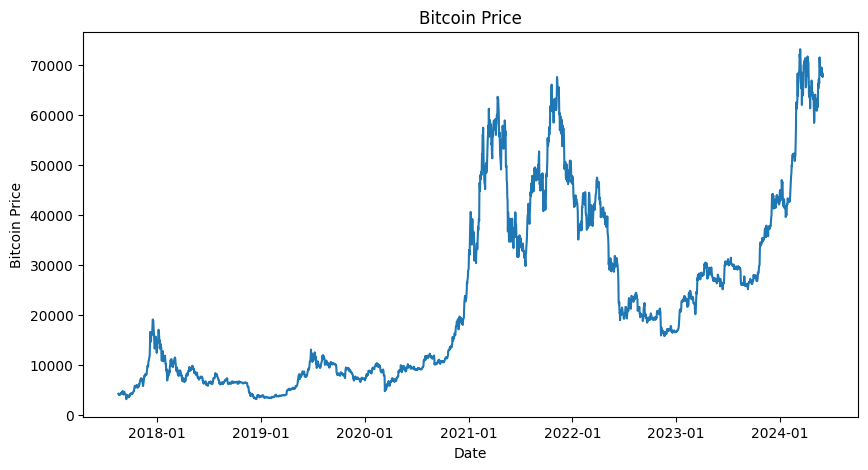

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Hiển thị biểu đồ về giá theo ngày
fig = plt.figure(figsize=(10, 5))
plt.plot(df.select('dateTime').collect(),df.select('close').collect())
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Bitcoin Price')
plt.show()

# Tiền xử lý dữ liệu

## Chuẩn hóa dữ liệu

In [13]:
# Hàm chuẩn hóa dữ liệu
def min_max_scaling(df, min_vals, max_vals):
    for column in df.columns:
        if column != "dateTime":
            min_val = min_vals[column]
            max_val = max_vals[column]
            df = df.withColumn(column, (col(column) - min_val) / (max_val - min_val))
    return df

In [14]:
# Tính giá trị min và max cho mỗi cột
min_values = df.select([spark_min(col(c)).alias(c) for c in df.columns if c != "datetTime "]).first()
max_values = df.select([spark_max(col(c)).alias(c) for c in df.columns if c != "datetTime "]).first()

In [15]:
dataset_norm = min_max_scaling(df, min_values, max_values)

In [16]:
dataset_norm.show()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  dateTime|                open|                high|                 low|               close|              volume|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2017-08-17|0.015360654859463675|0.017147256214051672|0.020195777967108197| 0.01568412920030876|7.456400770065937E-4|
|2017-08-18|0.015698356858253493| 0.01553208870194183|0.016372305785301126|0.013155488696903165|0.001277855742925...|
|2017-08-19|  0.0131697526175477|0.012882035466503784|0.015076701624886774|0.013607811702216671|2.014546618741573E-4|
|2017-08-20| 0.01335019153337637|0.013256360992120624|0.017742054013597127|0.012839532654759157|3.142433777551385E-4|
|2017-08-21|0.012608250467241594|0.011959065782334877| 0.01597853123024535|0.011833713634617658| 6.09663167336072E-4|
|2017-08-22|0.011847996510559405|0.011749134037613209|0.

## Vẽ sơ đồ

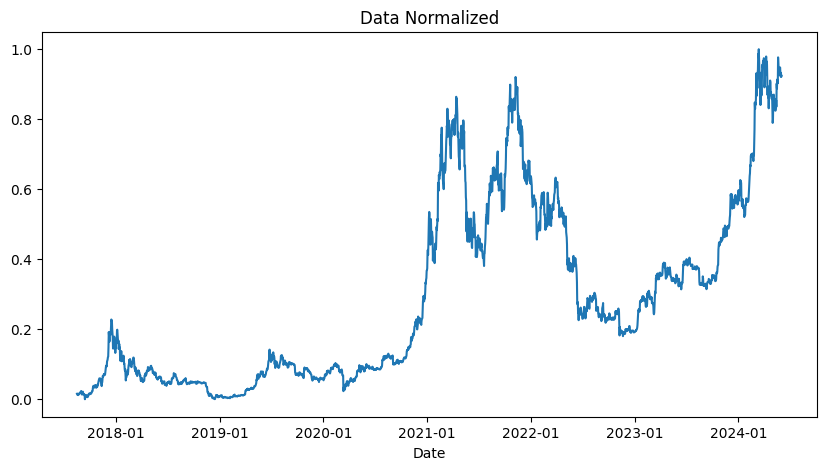

In [17]:
fig = plt.figure(figsize=(10, 5))
plt.plot(dataset_norm.select('dateTime').collect(), dataset_norm.select('close').collect())
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

## Chia dữ liệu

In [18]:
train_size = 0.8
count_data = length(dataset_norm.collect())
train_count = int(train_size * count_data)

training_data = dataset_norm.limit(train_count)

testing_data = dataset_norm.subtract(training_data).orderBy('dateTime')

## Vẽ biểu đồ các tập dữ liệu đã chia

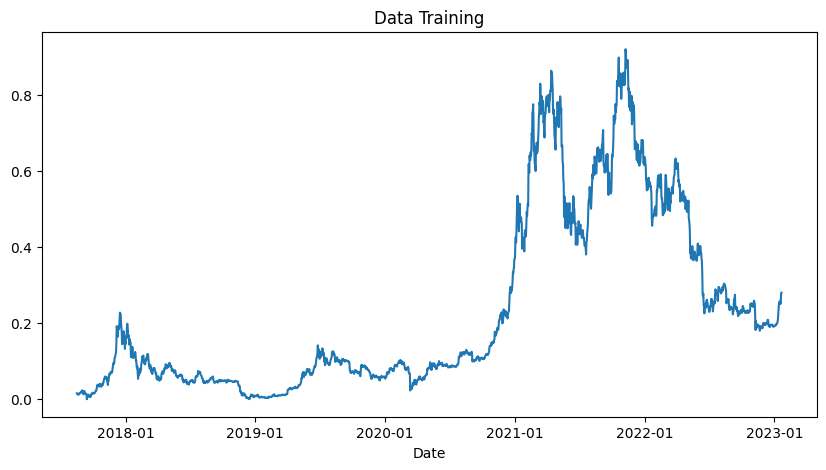

In [19]:
# Train
fig = plt.figure(figsize=(10, 5))
plt.plot(training_data.select('dateTime').collect(), training_data.select('close').collect())
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

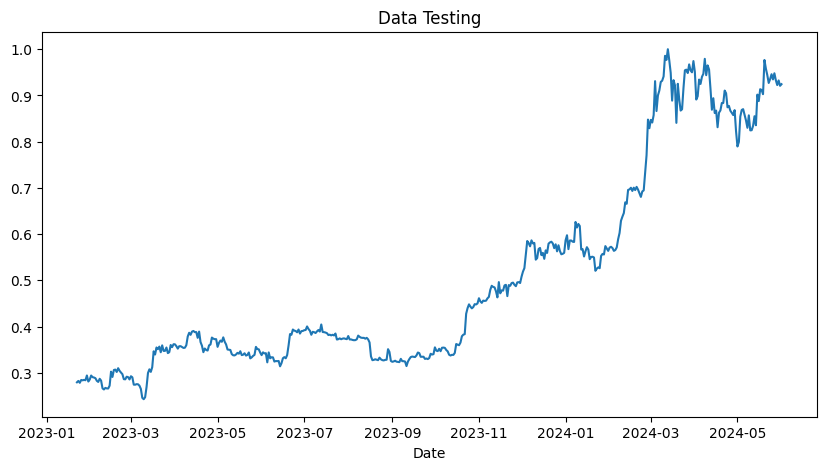

In [20]:
# Test
fig = plt.figure(figsize=(10, 5))
plt.plot(testing_data.select('dateTime').collect(), testing_data.select('close').collect())
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Testing')
plt.show()

## Find lags

In [21]:
training_data.show()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  dateTime|                open|                high|                 low|               close|              volume|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2017-08-17|0.015360654859463675|0.017147256214051672|0.020195777967108197| 0.01568412920030876|7.456400770065937E-4|
|2017-08-18|0.015698356858253493| 0.01553208870194183|0.016372305785301126|0.013155488696903165|0.001277855742925...|
|2017-08-19|  0.0131697526175477|0.012882035466503784|0.015076701624886774|0.013607811702216671|2.014546618741573E-4|
|2017-08-20| 0.01335019153337637|0.013256360992120624|0.017742054013597127|0.012839532654759157|3.142433777551385E-4|
|2017-08-21|0.012608250467241594|0.011959065782334877| 0.01597853123024535|0.011833713634617658| 6.09663167336072E-4|
|2017-08-22|0.011847996510559405|0.011749134037613209|0.

In [22]:
def create_sliding_windows_rdd(rdd, lag):
    def sliding_window(index, iterator):
        data = list(iterator)
        x = []
        y = []
        for i in range(lag, len(data)):
            x.append([list(t[1:]) for t in data[i-lag:i]])
            y.append(data[i][1])
        return zip(x, y)
    
    return rdd.mapPartitionsWithIndex(sliding_window)

In [23]:
lag=1

training_windows_rdd = create_sliding_windows_rdd(training_data.rdd, lag)
testing_windows_rdd = create_sliding_windows_rdd(testing_data.rdd, lag)


x_train, y_train = zip(*training_windows_rdd.collect())
x_test, y_test = zip(*testing_windows_rdd.collect())




In [24]:
x_train

([[0.015360654859463675,
   0.017147256214051672,
   0.020195777967108197,
   0.01568412920030876,
   0.0007456400770065937]],
 [[0.015698356858253493,
   0.01553208870194183,
   0.016372305785301126,
   0.013155488696903165,
   0.0012778557429253172]],
 [[0.0131697526175477,
   0.012882035466503784,
   0.015076701624886774,
   0.013607811702216671,
   0.0002014546618741573]],
 [[0.01335019153337637,
   0.013256360992120624,
   0.017742054013597127,
   0.012839532654759157,
   0.0003142433777551385]],
 [[0.012608250467241594,
   0.011959065782334877,
   0.01597853123024535,
   0.011833713634617658,
   0.000609663167336072]],
 [[0.011847996510559405,
   0.011749134037613209,
   0.008508922601460784,
   0.01217714290006353,
   0.0009712016977426333]],
 [[0.01219142085095866,
   0.014032521821653748,
   0.017468685177389327,
   0.013236189543580815,
   0.0010165043802212307]],
 [[0.013722521035238673,
   0.015534360405688612,
   0.018506687874739684,
   0.0161267191944169,
   0.0007354732

In [25]:
# Xavier
def create_matrix(size1, size2):
    limit = np.sqrt(6 / (size1 + size2))
    return np.random.uniform(-limit, limit, size=(size1, size2))
    

In [26]:
import numpy as np
np.random.seed(1234)
class GRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.W_z = np.random.randn(hidden_size, input_size)
        self.U_z = np.random.randn(hidden_size, hidden_size)
        self.b_z = np.zeros((hidden_size, 1))
        
        self.W_r = np.random.randn(hidden_size, input_size)
        self.U_r = np.random.randn(hidden_size, hidden_size)
        self.b_r = np.zeros((hidden_size, 1))
        
        self.W_h = np.random.randn(hidden_size, input_size)
        self.U_h = np.random.randn(hidden_size, hidden_size)
        self.b_h = np.zeros((hidden_size, 1))
        
        self.W_out = np.random.randn(output_size, hidden_size)
        self.b_out = np.zeros((output_size, 1))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def forward(self, x, h_prev):
        z_t = self.sigmoid(np.dot(self.W_z, x) + np.dot(self.U_z, h_prev) + self.b_z)
        r_t = self.sigmoid(np.dot(self.W_r, x) + np.dot(self.U_r, h_prev) + self.b_r)
        h_hat_t = self.tanh(np.dot(self.W_h, x) + np.dot(self.U_h, r_t * h_prev) + self.b_h)
        h_t = (1 - z_t) * h_prev + z_t * h_hat_t

        y_t = np.dot(self.W_out, h_t) + self.b_out
        return y_t, h_t
    
    def train(self, X_train, y_train, learning_rate=0.001, epochs=100):
        for epoch in range(epochs):
            total_loss = 0
            for i in range(len(X_train)):
                h_prev = np.zeros((self.hidden_size, 1))
                for t in range(len(X_train[i])):
                    x_t = np.array(X_train[i][t]).reshape(-1, 1)
                    y_t = np.array(y_train[i]).reshape(-1, 1)
                    
                    # Forward với h_prev để ra y và h của hiện tại (biến tên h_prev vì nó sẽ lưu lại và sử dụng cho lượt tiếp theo)
                    y_pred, h_prev = self.forward(x_t, h_prev)
                    
                    # Tính hàm mất mát
                    loss = np.mean((y_pred - y_t) ** 2)
                    total_loss += loss
                    
                    # Backward pass (Gradient Descent)
                    grad_y_pred = 2 * (y_pred - y_t)
                    self.W_out -= learning_rate * np.dot(grad_y_pred, h_prev.T)
                    self.b_out -= learning_rate * grad_y_pred
            
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(X_train)}')

    def predict(self, X_test):
        predictions = []
        for i in range(len(X_test)):
            h_prev = np.zeros((self.hidden_size, 1))
            for t in range(len(X_test[i])):
                x_t = np.array(X_test[i][t]).reshape(-1, 1)
                
                # Forward pass
                y_pred, h_prev = self.forward(x_t, h_prev)
            
            predictions.append(y_pred.flatten()[0])
        return predictions

input_size = 5
hidden_size = 120
output_size = 1
gru = GRU(input_size, hidden_size, output_size)

# Huấn luyện mô hình
gru.train(x_train, y_train, learning_rate=0.001, epochs=100)


Epoch 1/100, Loss: 0.01528577872581944
Epoch 2/100, Loss: 0.011039547457922601
Epoch 3/100, Loss: 0.010573897310243257
Epoch 4/100, Loss: 0.010346837087891265
Epoch 5/100, Loss: 0.010188108010949383
Epoch 6/100, Loss: 0.010040052341200204
Epoch 7/100, Loss: 0.009886528730477557
Epoch 8/100, Loss: 0.009725538418250983
Epoch 9/100, Loss: 0.009559101893258823
Epoch 10/100, Loss: 0.009389787720031628
Epoch 11/100, Loss: 0.009219708706349476
Epoch 12/100, Loss: 0.00905036951855125
Epoch 13/100, Loss: 0.008882764697981152
Epoch 14/100, Loss: 0.00871751838441655
Epoch 15/100, Loss: 0.008555003387388151
Epoch 16/100, Loss: 0.0083954283569242
Epoch 17/100, Loss: 0.008238897308491774
Epoch 18/100, Loss: 0.008085448753367568
Epoch 19/100, Loss: 0.007935080834496887
Epoch 20/100, Loss: 0.007787767226844919
Epoch 21/100, Loss: 0.007643467083568995
Epoch 22/100, Loss: 0.007502131201378867
Epoch 23/100, Loss: 0.007363705810788917
Epoch 24/100, Loss: 0.007228134886690975
Epoch 25/100, Loss: 0.00709536

In [27]:
# Dự đoán
predictions = gru.predict(x_test)
print("Predictions:", np.array(predictions))

Predictions: [0.35921856 0.38007492 0.36505612 0.37619808 0.38408235 0.37414712
 0.31869367 0.40201234 0.3555247  0.37966598 0.40822939 0.4060142
 0.40917581 0.33609366 0.34647107 0.36600508 0.39848195 0.37121776
 0.33373617 0.34848089 0.31581658 0.32101432 0.34931741 0.37365848
 0.42721736 0.40934301 0.5068709  0.39575754 0.40218009 0.44587378
 0.43770886 0.44306819 0.43532183 0.37755894 0.35399519 0.36517944
 0.38914298 0.37420609 0.40167592 0.37651989 0.33738641 0.28483466
 0.30934132 0.33941326 0.35597823 0.33585874 0.2573245  0.3207787
 0.30131117 0.35744574 0.59674226 0.66476081 0.56473707 0.50524041
 0.73057452 0.50504126 0.53518327 0.60771475 0.58216121 0.41669489
 0.38731124 0.33462872 0.28608967 0.28992191 0.33390849 0.32410601
 0.34646317 0.34330806 0.34486625 0.27085881 0.28375632 0.33189489
 0.29369684 0.30615238 0.28687688 0.25823332 0.24612273 0.27321032
 0.34385706 0.34740421 0.33945713 0.33020778 0.36505632 0.29443123
 0.29503904 0.3284046  0.35162627 0.3518967  0.3303

In [28]:
y_test

(0.27928998107592284,
 0.28232057231940216,
 0.2782299434939727,
 0.2843612194254074,
 0.28363474055949445,
 0.28455783321403927,
 0.2838028753928149,
 0.29413377713271593,
 0.2810265824951439,
 0.28528719071822217,
 0.29396265186934806,
 0.2904986439046031,
 0.2896768625483938,
 0.2881852528095064,
 0.2825366378773145,
 0.28009845921061277,
 0.28696552067343506,
 0.28295074256902153,
 0.266294382580214,
 0.26382400788159976,
 0.2672128917718824,
 0.26607314665259346,
 0.2659624168970058,
 0.2720468800216233,
 0.3024260440186063,
 0.2909048952239426,
 0.305937144269612,
 0.30685023156007296,
 0.3017054342210107,
 0.30988152150216147,
 0.30425478981041004,
 0.3004133169090251,
 0.2969502871223331,
 0.28613012866831833,
 0.2857442234524791,
 0.29143618564638646,
 0.2905381343499957,
 0.2855224285659712,
 0.29250810110469316,
 0.290155079824482,
 0.2742576742129435,
 0.2741464972902459,
 0.27534375927904503,
 0.27504569445235577,
 0.272028574118062,
 0.2649570175462959,
 0.245751609395477

In [29]:
test_date = np.array([item[0:][0] for item in testing_data.collect()])

In [30]:
test_date = test_date[lag:]

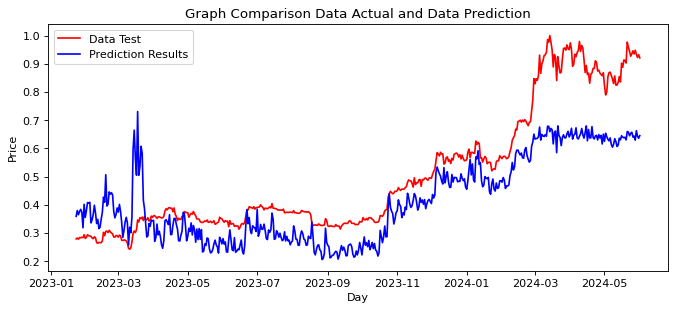

In [31]:
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparison Data Actual and Data Prediction')
plt.plot(test_date,y_test, color='red',label='Data Test')

plt.plot(test_date,predictions, color='blue',label='Prediction Results')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
mse = np.mean((np.array(predictions) - np.array(y_test)) ** 2)
mae = np.mean(np.abs(np.array(predictions) - np.array(y_test)))
rmse = np.sqrt(np.mean((np.array(predictions) - np.array(y_test)) ** 2))
mape =  np.mean(np.abs((np.array(y_test) - np.array(predictions)) / y_test)) * 100

In [33]:
print('mse: ', mse)
print('mae: ', mae)
print('rmse: ', rmse)
print('mape: ', mape)

mse:  0.019902626143244204
mae:  0.11653767141350545
rmse:  0.14107666760752538
mape:  23.12486362535675


In [34]:
def returnFromMinMax(scaled_data, col='close'):
    min_v = des_data[col]['min']
    max_v = des_data[col]['max']
    data = [d  * (max_v - min_v) + min_v for d in scaled_data]
    return data

In [35]:
predict_price = returnFromMinMax(predictions)

In [ ]:
predict_price

In [39]:
import csv
file_path = 'predict_output.csv'
# Mở file CSV để ghi
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Ghi tiêu đề cột (nếu cần)
    writer.writerow(['dateTime', 'close_predict'])

    # Ghi từng dòng dữ liệu
    for item1, item2 in zip(test_date, predict_price):
        writer.writerow([item1, item2])

print(f'Data has been written to {file_path}')

Data has been written to predict_output.csv


In [72]:
spark.stop()